In [2]:
import tensorflow as tf
import keras
import retina
import pandas as pd
import matplotlib.pyplot as plt

In [75]:
df = pd.read_csv(retina.filesys.TRAINING_DATA_CSV_PATH, index_col=False)
labels = df["label"]
df = df.drop(columns=["label"])
df

,texture-1,texture-2,texture-3,texture-4,texture-5,texture-6,texture-7,texture-8,texture-9,texture-10,...,texture-21,texture-22,texture-23,texture-24,texture-25,texture-26,texture-27,texture-28,texture-29,texture-30
0,0.396201,0.016282,0.023066,0.002714,0.023066,0.005427,0.001357,0.004071,0.009498,0.020353,...,0.199457,0.005427,0.020353,0.004071,0.013569,0.006784,0.000000,0.004071,0.004071,0.010855
1,0.396450,0.018935,0.048521,0.007101,0.021302,0.004734,0.000000,0.007101,0.008284,0.022485,...,0.134911,0.002367,0.009467,0.004734,0.017751,0.001183,0.002367,0.003550,0.001183,0.023669
2,0.339009,0.021672,0.027864,0.013932,0.018576,0.003096,0.000000,0.010836,0.000000,0.023220,...,0.182663,0.017028,0.024768,0.009288,0.021672,0.000000,0.001548,0.006192,0.003096,0.013932
3,0.354691,0.024027,0.020595,0.006865,0.028604,0.003432,0.002288,0.005721,0.008009,0.042334,...,0.203661,0.006865,0.018307,0.006865,0.019451,0.004577,0.001144,0.004577,0.009153,0.013730
4,0.347982,0.023318,0.028700,0.017040,0.036771,0.002691,0.001794,0.009865,0.007175,0.034081,...,0.157848,0.009865,0.017937,0.002691,0.020628,0.001794,0.000897,0.008969,0.000897,0.017040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,0.332847,0.030657,0.032117,0.002920,0.020438,0.000000,0.000000,0.000000,0.001460,0.029197,...,0.160584,0.007299,0.014599,0.000000,0.024818,0.001460,0.000000,0.004380,0.001460,0.058394
406,0.332454,0.022427,0.031662,0.013193,0.018470,0.001319,0.000000,0.003958,0.001319,0.022427,...,0.149077,0.013193,0.014512,0.002639,0.029024,0.000000,0.000000,0.001319,0.001319,0.044855
407,0.344459,0.021362,0.025367,0.004005,0.024032,0.000000,0.000000,0.005340,0.000000,0.030708,...,0.142857,0.010681,0.009346,0.000000,0.014686,0.000000,0.000000,0.001335,0.000000,0.022697
408,0.339080,0.028736,0.016092,0.003448,0.031034,0.001149,0.001149,0.004598,0.009195,0.026437,...,0.143678,0.006897,0.014943,0.003448,0.031034,0.001149,0.000000,0.003448,0.000000,0.044828


In [76]:
dataset = tf.data.Dataset.from_tensor_slices((df, labels))
train_dataset, test_dataset = keras.utils.split_dataset(dataset, shuffle=True, seed=42, left_size=0.7)
train_dataset, validation_dataset = keras.utils.split_dataset(train_dataset, shuffle=True, seed=42, left_size=0.7)

train_dataset = train_dataset.repeat(20).shuffle(100).batch(16)
test_dataset = test_dataset.batch(16)
validation_dataset = validation_dataset.batch(16)

dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(30,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>

In [77]:
model = keras.Sequential([
  keras.layers.Input(shape=dataset.element_spec[0].shape),
  keras.layers.Dense(100, activation="sigmoid"),
  keras.layers.Dropout(0.3),
  keras.layers.Dense(500, activation="sigmoid"),
  keras.layers.Dense(6),
  keras.layers.Softmax(),
])

model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=0.005), # type: ignore
  loss=keras.losses.SparseCategoricalCrossentropy(),
  metrics=["accuracy"],
)

model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_54 (Dense)                │ (None, 100)            │         3,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 500)            │        50,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 6)              │         3,006 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_18 (Softmax)            │ (None, 6)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,606 (221.12 KB)

 Trainable params: 56,606 (221.12 KB)

 Non-trainable params: 0 (0.00 B)

In [79]:
history = model.fit(
  train_dataset, epochs=10,
  validation_data=validation_dataset,
  # callbacks=keras.callbacks.EarlyStopping(
  #   monitor='val_loss',
  #   min_delta=0,
  #   patience=3,
  #   verbose=0,
  #   mode='auto'
  # )
)

Epoch 1/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3069 - loss: 1.6283 - val_accuracy: 0.2791 - val_loss: 1.6947
Epoch 2/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3259 - loss: 1.6147 - val_accuracy: 0.2674 - val_loss: 1.6807
Epoch 3/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3392 - loss: 1.6150 - val_accuracy: 0.3488 - val_loss: 1.7020
Epoch 4/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3372 - loss: 1.6043 - val_accuracy: 0.3605 - val_loss: 1.6826
Epoch 5/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3356 - loss: 1.6055 - val_accuracy: 0.3488 - val_loss: 1.6543
Epoch 6/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3602 - loss: 1.5757 - val_accuracy: 0.3721 - val_loss: 1.6826
Epoch 7/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3599 - loss: 1.5710 - val_accuracy: 0.3605 - val_loss: 1.6357
Epoch 8/10
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3585 - loss: 1.5614 - val_accuracy: 0.

In [12]:
model.evaluate(test_dataset)

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3125 - loss: 1.6313

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3069 - loss: 1.5739 


[1.6038748025894165, 0.27642276883125305]

In [50]:
model.save(retina.filesys.EXPRESSION_RECOGNITION_MODEL_PATH)

FileNotFoundError: [Errno 2] No such file or directory: 'models\\expression_recognition.keras'

C:\Users\Irsan\AppData\Local\Temp\ipykernel_14860\469801421.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  accuracy_fig.show()


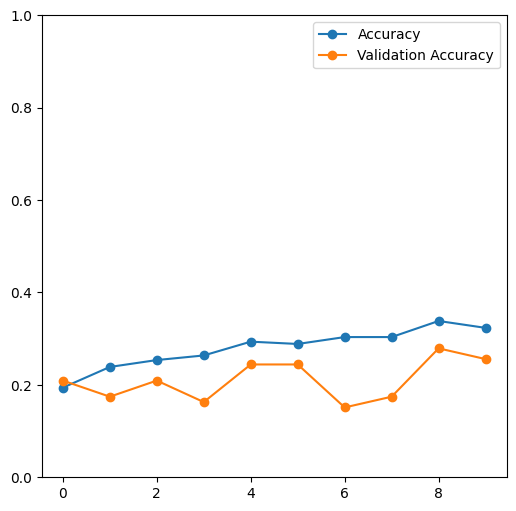

In [51]:
accuracy_fig = plt.figure(figsize=(6,6))
ax = accuracy_fig.add_subplot()
ax.plot(history.history["accuracy"], label="Accuracy", marker='o')
ax.plot(history.history["val_accuracy"], label="Validation Accuracy", marker='o')
ax.legend()
ax.set_ylim(0, 1)
accuracy_fig.show()